# Array processing and curve fitting with Sandia PSL Uncertainty Calculator


To work with arrays in the uncertainty calculator, the uarray module is provided.

    >>> from suncal import uarray

### 1. Set up an array object with x, y, u(x), and u(y) data
    
First, set up an array object for the calculator to use.

1. If uncertainties in the data points are known, use `uarray.Array`.
2. If the data is a collection of measurements at each x value, use `dataset.DataSet` and call `summarize()`.

Note x and y are required 1D arrays. ux and uy are optional. They may be scalars which apply
to the entire x or y, or they may be arrays the same length as x and y.

### 2. Operate on the array

Then, determine what are the desired parameters from the array and use one of the provided
InputFunc classes:

1. To determine x value and uncertainty of a threshold crossing, use `uarray.ArrayThresh`
2. To fit any linear or nonlinear function to the array, use `curvefit.CurveFit`
3. To use the array for any other type uncertainty calculations, use `uarray.ArrayFunc`


### 3. Going further by using the array in UncertaintyCalc

The results from an `ArrayFunc` or `ArrayThresh` can be used as a function to an `UncertaintyCalc` object. For example, define two `ArrayThresh` objects and subtract them to find the uncertainty of a pulse width.

A line or curve fit results in multiple mean values (e.g. slope and intercept). To use this in an `UncertaintyCalc` object, use `curvefit.CurveFitParam` which wraps the fit class and returns a single parameter for the calculator to use.

In [1]:
import suncal
from suncal import uarray
from suncal import curvefit

import scipy
import numpy as np
import matplotlib.pyplot as plt

## Examples

### Linear fit

Find the uncertainty in the slope of a line. Note `a` and `u(a)` are the intercept and uncertainty of the intercept, while `b` and `u(b)` are the slope and uncertainty of slope.

In [2]:
# Make up some line data with scatter
a, b = 10, 0.5
uy = 2.0
x = np.arange(50, 105, step=5)
y = a + b * x + np.random.normal(loc=0, scale=uy, size=len(x))

# Put x, y into Array. Array class can be accessed via uarray or curvefit module.
arr = curvefit.Array(x, y, uy=uy)

# Configure line fit calculation
fit = curvefit.CurveFit(arr, func='line')
out = fit.calculate(gum=True, mc=True, lsq=True, mcmc=True)
out




Method                   |b     |u(b)  |a   |u(a) 
-------------------------|------|------|----|-----
Least Squares            |0.531 |0.038 |7.6 |2.9  
GUM Approximation        |0.531 |0.038 |7.6 |2.9  
Monte Carlo              |0.531 |0.038 |7.6 |2.9  
Markov-Chain Monte Carlo |0.531 |0.033 |7.6 |2.6  



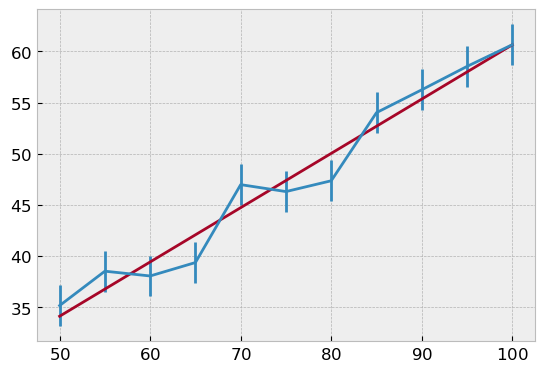

In [3]:
# Use the Calculator's built-in functions to plot the fit line (using least-squares analytical result)
ax = out.lsq.plot_points(ebar=True)
out.lsq.plot_fit(ax=ax);

Note that the uncertainty of the slope and uncertainty of the intercept cannot be directly used to predict the uncertainty of a point on the line (due to correlation between parameters). However, the Calculator output provides a `y` function to predict a point on the line, and functions `u_conf` and `u_pred` to determine a confidence band (confidence that the fit line passes through the true mean) and a prediction band (uncertainty for a new observation at a given x value). Note these are at k=1.

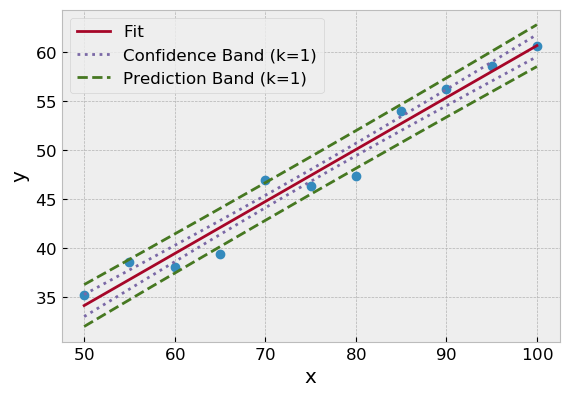

In [4]:
# Use the builtin functions to plot the fit line (using least-squares analytical result)
out.lsq.plot_summary();

### Curve fit

Fitting a non-linear curve is a similar process, but a function to fit must also be specified. In this case, we fit data points to a normal curve to find the center and standard deviation.




Method                   |center |u(center) |stddev |u(stddev) |offst   |u(offst) 
-------------------------|-------|----------|-------|----------|--------|---------
Least Squares            |20.046 |0.077     |3.931  |0.063     |7.99944 |0.00037  
GUM Approximation        |20.05  |0.11      |3.93   |0.12      |7.99944 |0.00037  
Monte Carlo              |20.047 |0.076     |3.929  |0.060     |7.99945 |0.00036  
Markov-Chain Monte Carlo |20.044 |0.077     |3.938  |0.063     |7.99944 |0.00037  



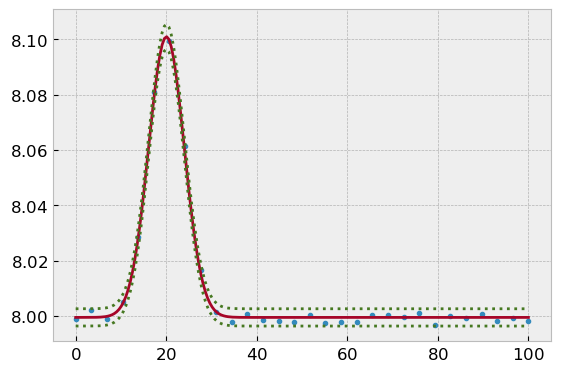

In [5]:
# Make up some fake data
uy = 0.002
x = np.linspace(0,100, num=30)
y = 8 + scipy.stats.norm.pdf(x, loc=20, scale=4) + np.random.normal(loc=0, scale=uy, size=len(x))

# Put data in an Array
arr = curvefit.Array(x, y, uy=uy)

# Define a function to fit the data to. Function takes x values as first parameter, and 
# any other parameters needed to describe the function will be fit. In this case
# we'll fit to a normal function with center a and standard deviation b.
def norm(x, center, stddev, offst):
    return offst + scipy.stats.norm.pdf(x, loc=center, scale=stddev)

# Set up the calculator using ArrayCurveFit. Give it an initial guess p0 to help the solution converge.
n = curvefit.CurveFit(func=norm, arr=arr, p0=(18, 5, 8))

# Run the fit calculation and plot
display(n.calculate(gum=True, mc=True, lsq=True, mcmc=True))
plt.plot(x, y, marker='.', ls='')

xx = np.linspace(0, 100, num=200)
fit = n.out.lsq.y(xx)   # .y() returns fit line y for given x range
plt.plot(xx, fit);

# Prediction/Confidence bands can also be shown as before
u_pred = n.out.lsq.u_pred(xx)  # .u_pred() gives prediction band for given x range
plt.plot(xx, fit+u_pred*2, ls=':', color='C3')  # k=2
plt.plot(xx, fit-u_pred*2, ls=':', color='C3');

Suppose we need to use the center value in a larger uncertainty calculation. To put this ArrayCurveFit into an UncertaintyCalc, we need to tell it which fit parameter to use. For that, there is the ArrayFitParam class.

Let's say we need to find the distance between two peaks.

In [6]:
# Make data for a second peak and make a curvefit for it.
y2 = 8 + scipy.stats.norm.pdf(x, loc=65, scale=2) + np.random.normal(loc=0, scale=uy, size=len(x))
arr2 = curvefit.Array(x, y2, uy=uy)
n2 = curvefit.CurveFit(func=norm, arr=arr2, p0=(60, 5, 8))

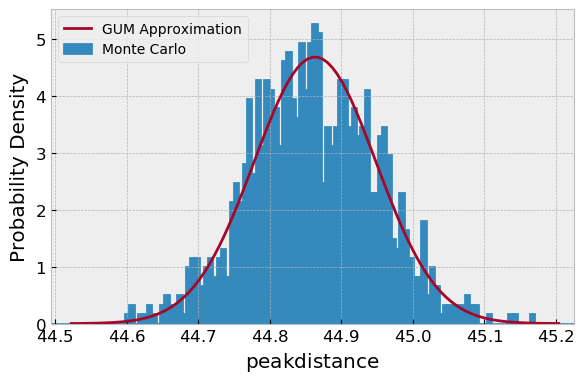

In [7]:
# Use CurveFitParam to pull the center value from each curve fit
center = curvefit.CurveFitParam(n, pidx=0, name='center1')    # pidx is index to coefficient. Here we want center, which is the first (0) coefficient.
center2 = curvefit.CurveFitParam(n2, pidx=0, name='center2')

u = suncal.UncertaintyCalc(samples=1000)
u.set_function(center, show=False)  # Add the fit function center value, give it a name
u.set_function(center2, show=False)
u.set_function('center2 - center1', name='peakdistance')     # Use the calculator to take the difference
u.calculate()
u.out.plot_pdf();

Note the least-squares analytical solutions aren't used by the calculator because an analytical uncertainty propagation is not typically possible.

### Pulse Width

Find uncertainty in the width of a pulse. For this example, we'll start by defining two ArrayThresh functions, one for the rising edge and one for the falling edge.


Method            |Mean     |Standard Uncertainty 
------------------|---------|---------------------
Least Squares     |5.00e-07 |9.0e-08              
Monte Carlo       |4.00e-07 |6.7e-08              
GUM Approximation |5.00e-07 |8.2e-08              




Method            |Mean      |Standard Uncertainty 
------------------|----------|---------------------
Least Squares     |5.500e-06 |9.0e-08              
Monte Carlo       |5.600e-06 |5.9e-08              
GUM Approximation |5.500e-06 |8.2e-08              



/Users/cjdelke/miniconda3/envs/uncertosx/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


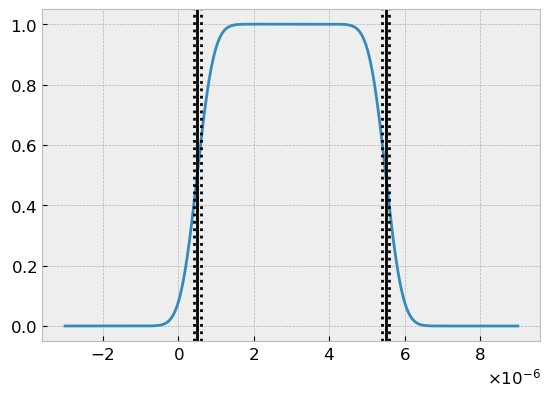

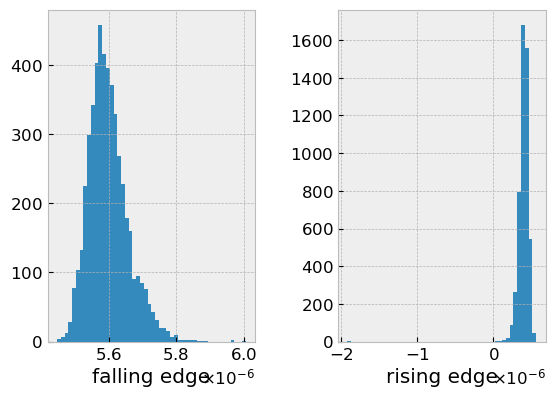

In [8]:
# Make a pulse
x = np.linspace(-3E-6,3E-6,num=500)
y = (1 + scipy.special.erf((x-.5E-6)*2000000)) * 0.5
x = np.append(x, x+x[-1]*2)
y = np.append(y, y[::-1])

# Use pulse x, y in Array object, with some uncertainty in y
arr = uarray.Array(x, y, uy=.1)

# Define functions that operate on the array (rising and falling threshold crossings)
rise = uarray.ArrayThresh(arr, thresh=0.5, edge='first', name='rise')
fall = uarray.ArrayThresh(arr, thresh=0.5, edge='last', name='fall')

# Find the rise and fall times
display(rise.calculate())
display(fall.calculate())

# Plot the reults
plt.plot(x, y)
plt.axvline(fall.out.lsq.mean, ls='-', color='black')
plt.axvline(fall.out.lsq.mean - fall.out.lsq.uncert, ls=':', color='black')
plt.axvline(fall.out.lsq.mean + fall.out.lsq.uncert, ls=':', color='black')

plt.axvline(rise.out.lsq.mean, ls='-', color='black')
plt.axvline(rise.out.lsq.mean - rise.out.lsq.uncert, ls=':', color='black')
plt.axvline(rise.out.lsq.mean + rise.out.lsq.uncert, ls=':', color='black')

fig, ax = plt.subplots(ncols=2)
ax[0].hist(fall.sampledvalues, bins=50)
ax[1].hist(rise.sampledvalues, bins=50)
ax[0].set_xlabel('falling edge')
ax[1].set_xlabel('rising edge');

Now, we're interested in the total uncertainty in the width of the pulse, fall-rise. The rise and fall variables defiend above can be used as functions in an UncertaintyCalc.




Method            |Mean      |Standard Uncertainty 
------------------|----------|---------------------
GUM Approximation |5.00e-06  |1.3e-07              
Monte Carlo       |5.200e-06 |9.2e-08              



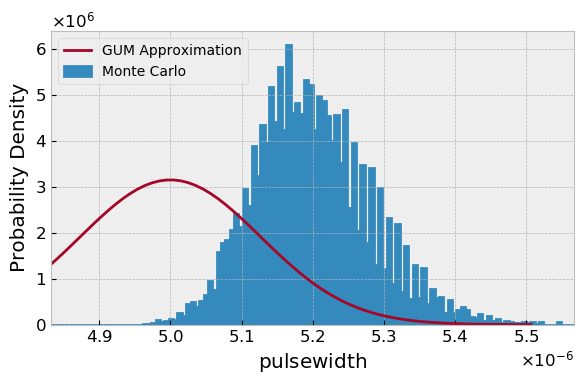

In [9]:
u = suncal.UncertaintyCalc(samples=10000)
u.set_function(rise, show=False)
u.set_function(fall, show=False)
u.set_function('fall-rise', name='pulsewidth')
display(u.calculate())
u.out.plot_pdf();

Notice the GUM expected pulse width is noticably lower than the Monte Carlo value. Because the edge finding algorithm detects the first edge (or last edge), the width of the noisy Monte Carlo samples will tend to be slightly higher than the result computed using the GUM, which uses expected value right at the threshold crossing.

### Area under the curve

In some cases, the quantity of interest may not be determined from a curve fit or threshold crossing. For these cases, the generic `ArrayFunc` class can be used. It must be provided with a function that takes x and y arrays as the only inputs, and returns a scalar value.

For this example, we'll compute a numerical integration of a curve using the `ArrayFunc` class, using trapezoidal numeric integration np.trapz.


Method            |Mean  |Standard Uncertainty 
------------------|------|---------------------
GUM Approximation |-23.1 |1.1                  
Monte Carlo       |-23.1 |1.1                  



Trapz Nominal -23.1132067042048


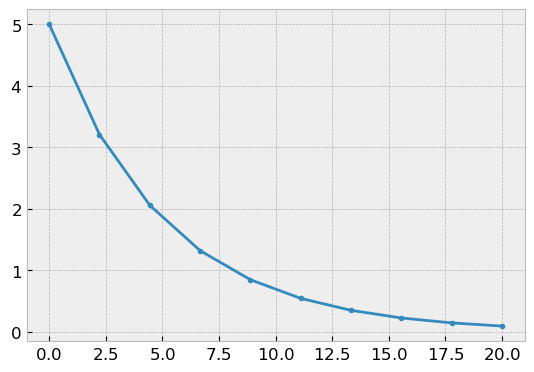

In [10]:
x = np.linspace(0, 20, num=10)
y = 5 * np.exp(-x/5)

# Put data in an array. Since this is exponential, make uy variable with x too!
arr = uarray.Array(x, y, uy=y/10)

# Set up ArrayFunc
f = uarray.ArrayFunc(function=lambda y=[0], x=None: np.trapz(y, x), arr=arr)

display(f.calculate())
print('Trapz Nominal', np.trapz(x, y))  # Check nominal value of trapz

plt.plot(x, y, marker='.');